In [1]:
from graph_tool.all import *
from tqdm import tqdm
from collections import Counter
from matplotlib.patches import Patch
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import plotly.express as px
import seaborn as sns

In [19]:
# load dysregnet results and extract edges with values

dys = pd.read_csv("../data/TCGA/dysreg_m_BRCA.csv", sep="\t")

sample_list = dys.iloc[:,0].tolist()
dys = dys[dys.columns[1:]]
dys.index = sample_list
# dys = dys.loc[(dys!=0).any(axis=1)]
# for first row only
dys_edges = dict(zip([e.replace("(", "").replace(")", "").replace("'", "").replace(" ", "") for e in dys.columns.tolist()], dys.iloc[1].tolist()))

In [53]:
keys = [k for k, v in dys_edges.items() if v != 0.0]
dys_edges_file = open("../data/TCGA/BRCA/TCGA-B6-A40B-01A_dysreg_edges_BRCA.csv", "w")
dys_edges_file.write("REM,GENE\n")
for e in keys:
    dys_edges_file.write(e+"\n")

In [20]:
# print edges to file to upload to REMnet app

dys_edges_file = open("../data/TCGA/BRCA/dysreg_edges_BRCA.csv", "w")
dys_edges_file.write("REM,GENE\n")
for e in dys_edges.keys():
    dys_edges_file.write(e+"\n")

In [20]:
g = load_graph("../data/graph-tool/CTID_0000055.gt")
epi_edges = {}
edges_to_mean = {}
for e in tqdm(g.edges()):
    e_name = f"{g.vp.name[e.source()]},{g.vp.name[e.target()]}"
    if e_name in dys_edges:
        if epi_edges.get(e_name) == None:
            edges_to_mean[e_name] = 1
            epi_edges[e_name] = g.ep["R_ENCBS610XAP"][e]
        else:
            edges_to_mean[e_name] += 1
            epi_edges[e_name] = epi_edges.get(e_name) + g.ep["R_ENCBS610XAP"][e]

2404861it [00:08, 270930.08it/s]


In [21]:
epi_edges_vals = []
for e in dys_edges:
    epi_edges_vals.append(epi_edges[e]/edges_to_mean[e])
dys_zscores = list(dys_edges.values())
epi_zscores = list(stats.zscore(epi_edges_vals))

In [ ]:

fig = px.scatter(x= epi_zscores, y=dys_zscores, text=list(dys_edges.keys()))
fig.update_layout(
    xaxis_title="epi_zscore", yaxis_title="dys_zscore"
)
fig.update_traces(mode="markers")
    
fig.show()

In [ ]:
zscores = stats.zscore(epi_edges_vals)
plt.hist(zscores)

plt.show()

## Heatmaps subtype specific and for all with clustering and normalization

In [5]:
meta = pd.read_csv('../data/TCGA/BRCA/TCGA-BRCA.GDC_phenotype.tsv', sep='\t', header = 0)

In [31]:
subtypes = pd.read_csv('../data/TCGA/BRCA/BRCA_subtypes_biolinks.csv', sep=',', header = 0)

In [32]:
s_samples = {}
for i in list(subtypes["pan.samplesID"]):
    s_samples["-".join(i.split("-")[:4])] = ""
s_samples.update(zip(s_samples, subtypes["Subtype_mRNA"]))
subtypes["pan.samplesID"] = s_samples.keys()

In [33]:
dys_samples = []
for i in list(dys.index):
    dys_samples.append("-".join(i.split("-")[:4]))

In [34]:
inter_sample = set(dys_samples).intersection(set(s_samples))
dys = dys.loc[dys.index.isin(inter_sample)]
subtypes = subtypes.loc[subtypes["pan.samplesID"].isin(inter_sample)]
dys_samples = []
for i in list(dys.index):
    dys_samples.append("-".join(i.split("-")[:4]))

In [20]:
#  write file for samples with associated subtype
samples_subtypes_file = open("../data/TCGA/BRCA/samples_subtypes_filt.csv", "w")
samples_subtypes_file.write("sample\tsubtype\n")
for i in subtypes.index:
    sa = subtypes["pan.samplesID"][i]
    su = subtypes["Subtype_mRNA"][i]
    samples_subtypes_file.write(f"{sa}\t{su}\n")
samples_subtypes_file.close()

In [7]:
all_row_numb = []
for c1, r1 in dys.iterrows():
    row_numb = []
    r1_list = list(r1)
    for c2, r2 in dys.iterrows():
        r2_list = list(r2)
        np1 = np.array(r1_list)
        np2 = np.array(r2_list)
        np3 = np1*np2
        numb = np.count_nonzero(np3)
        row_numb.append(numb)
    all_row_numb.append(row_numb)


In [8]:
same_edges = pd.DataFrame(all_row_numb, dys_samples, dys_samples)
sub_same_edges = same_edges
sub_same_edges["subtype"] = list(subtypes["Subtype_mRNA"])
sort_same_edges = sub_same_edges.sort_values("subtype")
cat = sort_same_edges["subtype"]
final_same_edges = sort_same_edges.drop(columns="subtype")
final_same_edges = final_same_edges[list(final_same_edges.index)]
lut = dict(zip(
    cat.unique(), 
    sns.color_palette('mako', cat.unique().size)
))

col_colors = cat.map(lut)
normalized_df = (final_same_edges-final_same_edges.values.min())/(final_same_edges.values.max()-final_same_edges.values.min())

/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering 

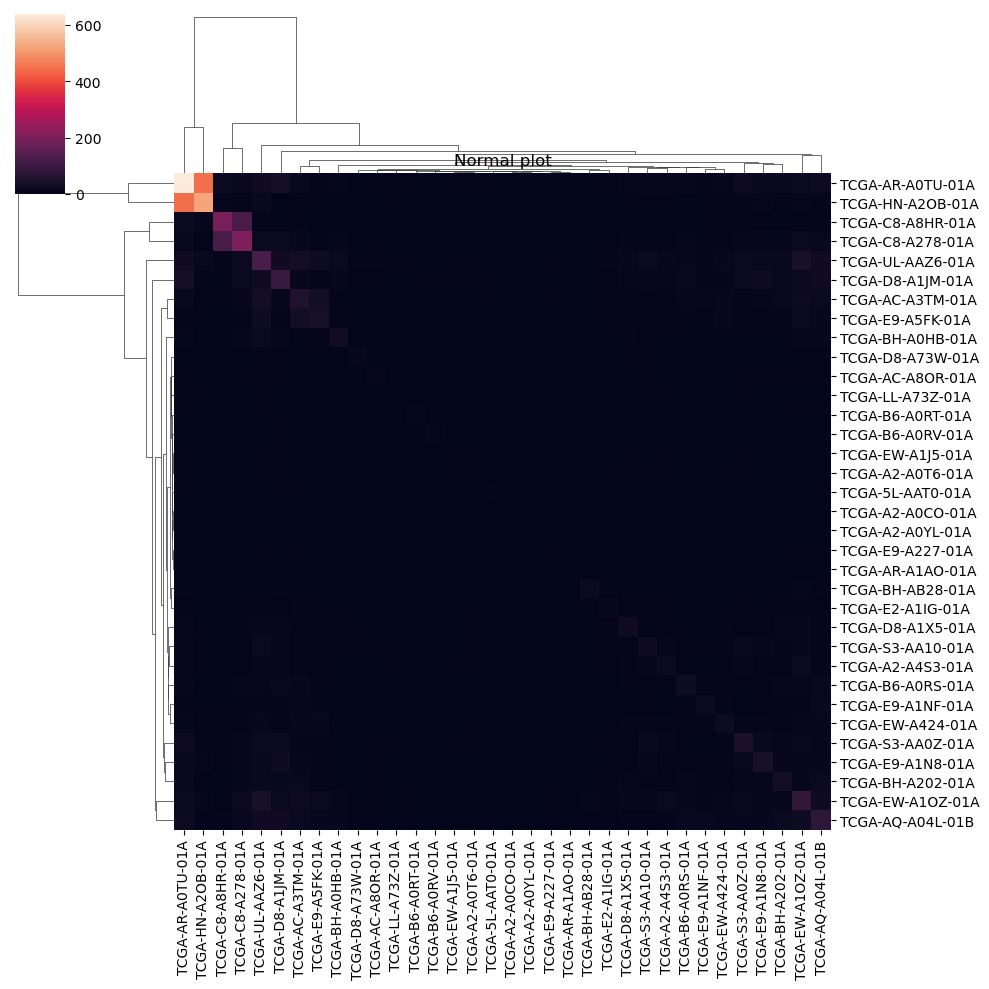

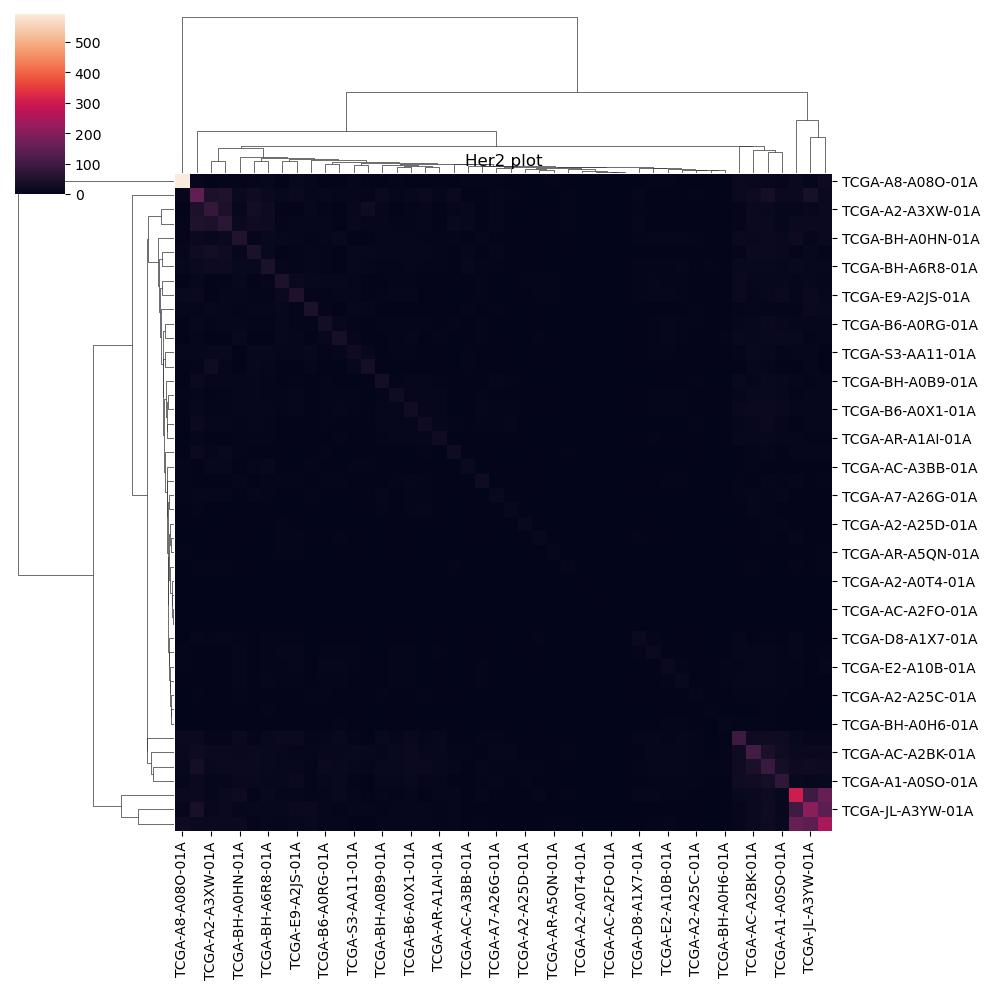

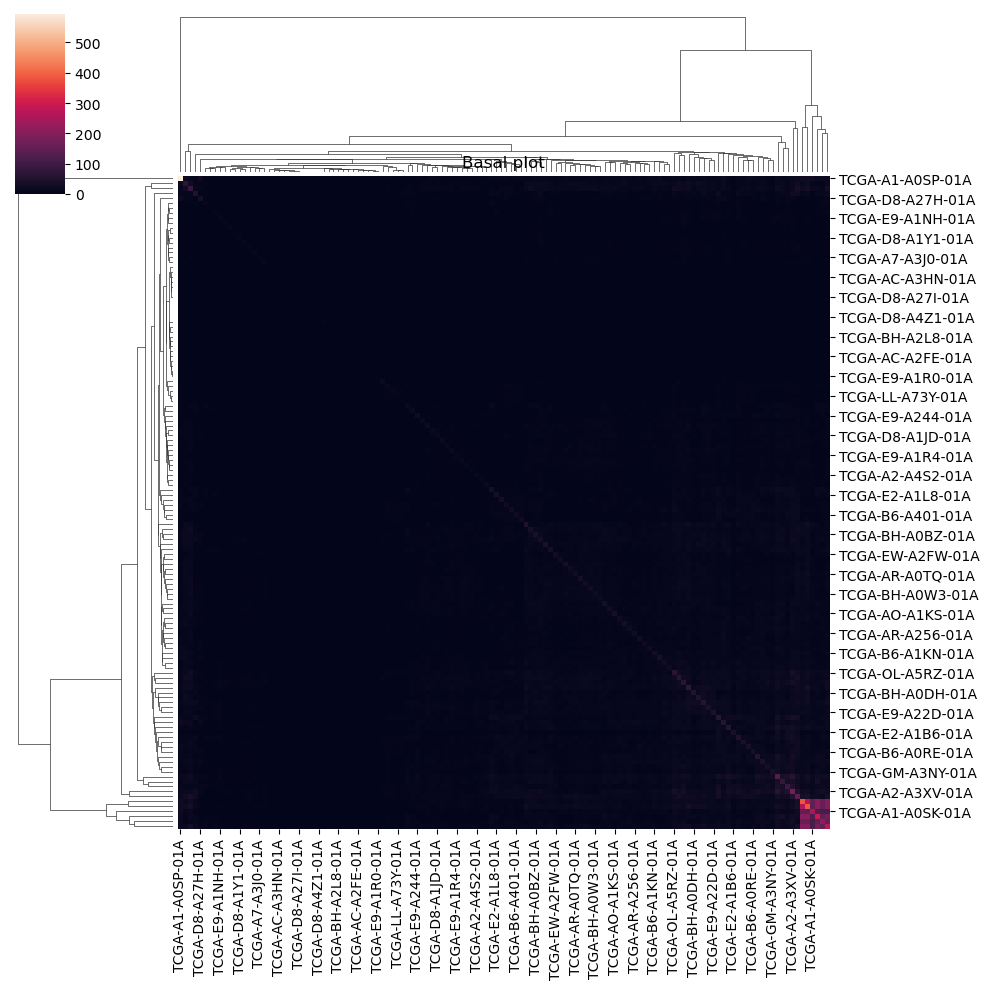

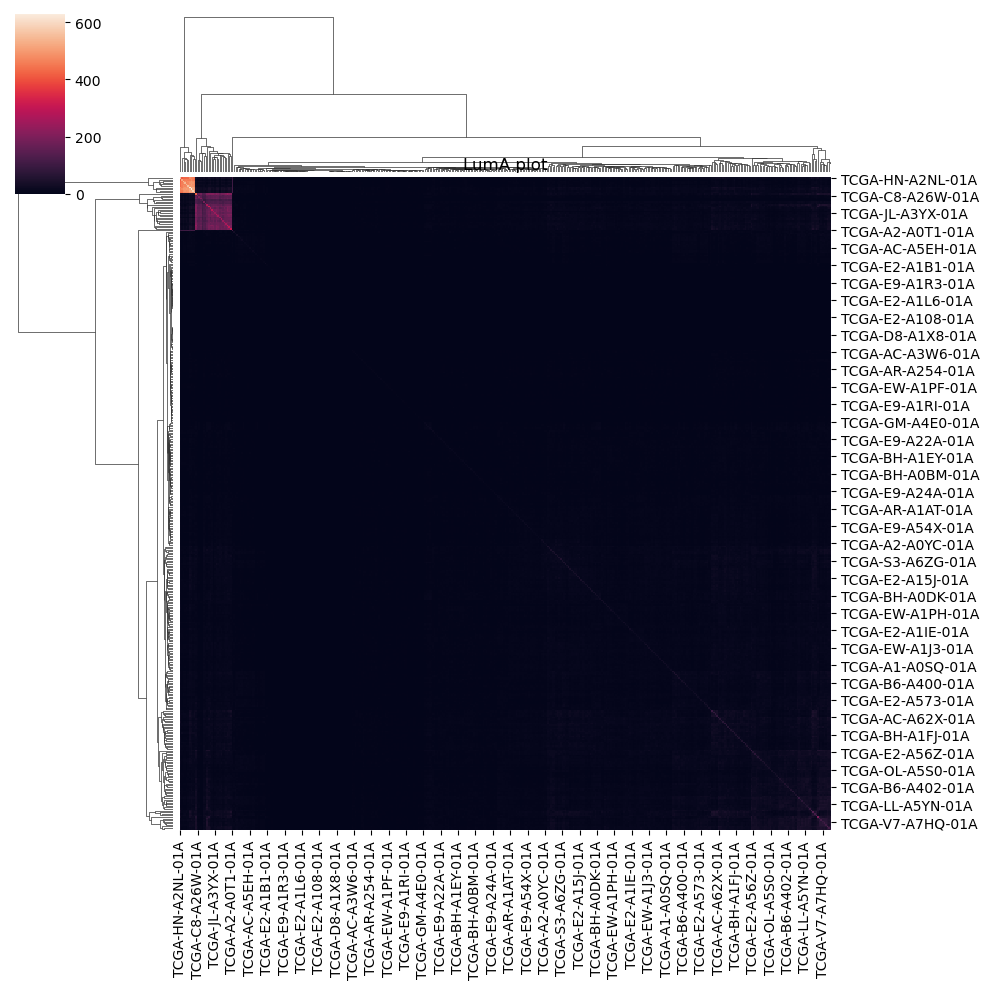

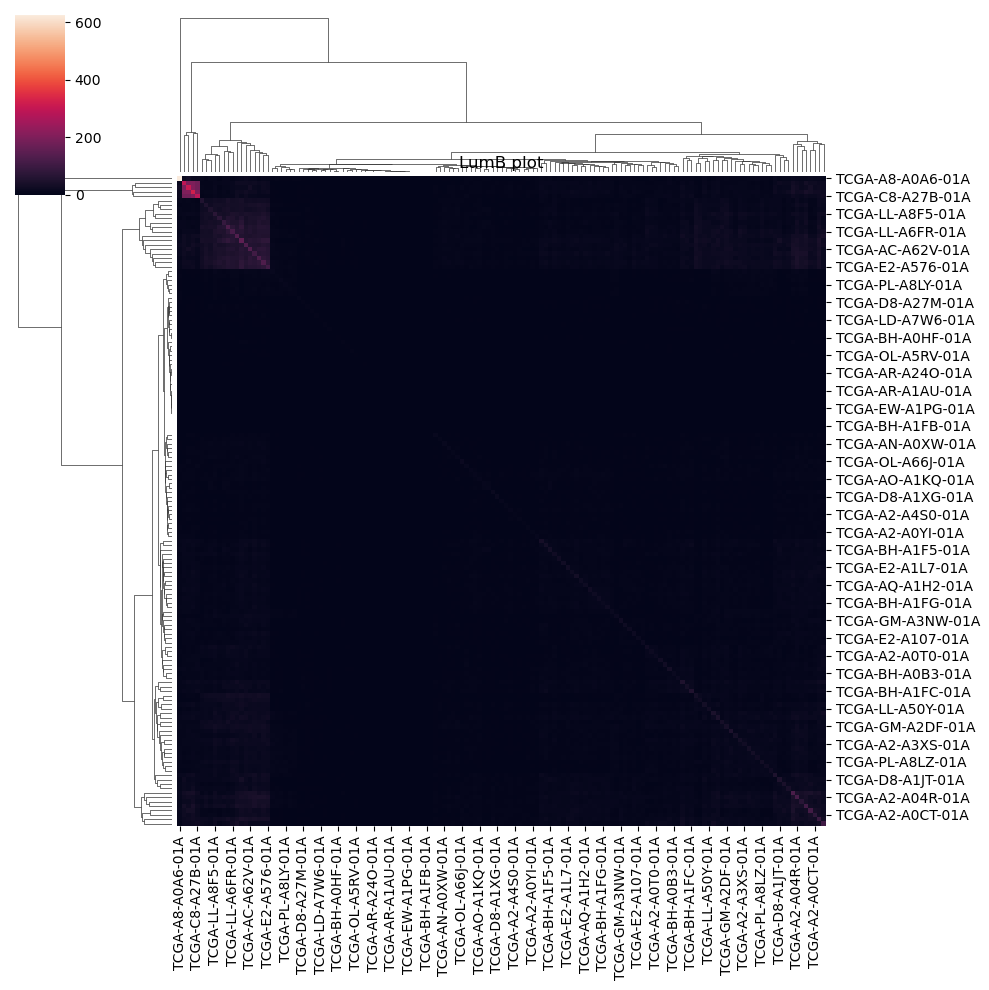

In [166]:
for subt in set(sub_same_edges["subtype"]):
    df = sub_same_edges.loc[sub_same_edges["subtype"] == subt].drop(columns="subtype")
    df = df.loc[:,df.columns.isin(df.index)]
    clustmap = sns.clustermap(df)
    clustmap.ax_heatmap.set_title(f'{subt} plot')
    fig = clustmap.fig
    clustmap.savefig(f"../data/figures/BRCA_{subt}_clustmap.png")

/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/nfs/home/students/s.doetsch/.conda/envs/rem/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


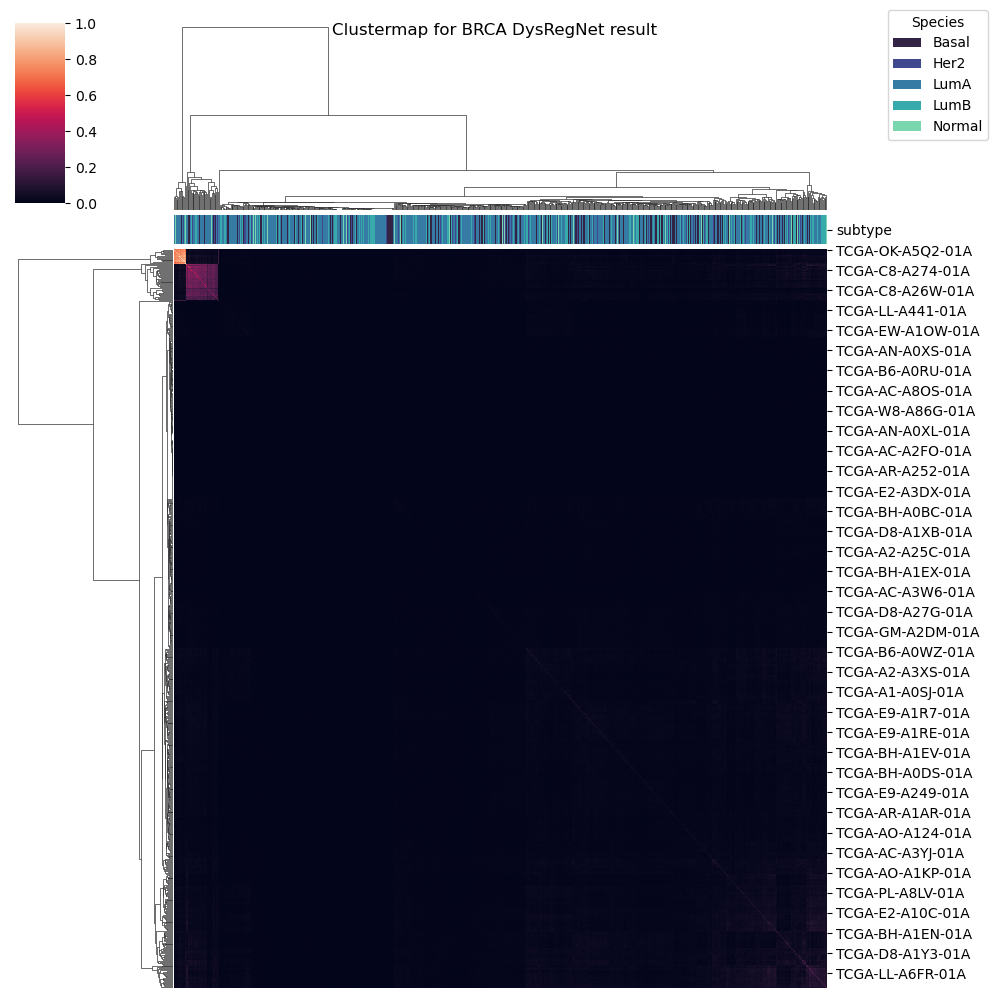

In [25]:
allclust = sns.clustermap(normalized_df, xticklabels=False, col_colors=col_colors)
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
allclust.fig.suptitle('Clustermap for BRCA DysRegNet result') 
allc
allclust.savefig(f"../data/figures/BRCA_clustmap.png")

## Subtype Distribution

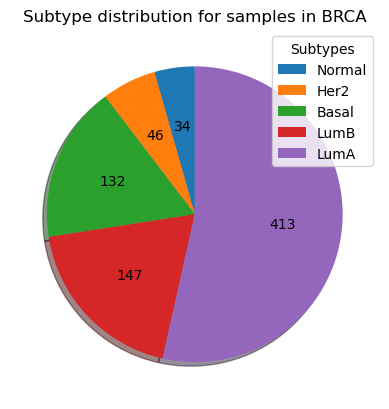

In [9]:
numb_subtypes = dict(Counter(list(cat)))
sorted_numb_subtypes = dict(sorted(numb_subtypes.items(), key=lambda x:x[1]))
y = np.array(list(sorted_numb_subtypes.values()))
total = sum(y)
mylabels = list(sorted_numb_subtypes.keys())

# def absolute_value(val):
#     a  = np.round(int(val/100.*y.sum()), 0)
#     return a


plt.pie(y, autopct=lambda p: '{:.0f}'.format(p * total / 100) , startangle=90, shadow = True)
plt.legend(title="Subtypes", labels=mylabels )
plt.title("Subtype distribution for samples in BRCA")
plt.savefig("../data/figures/subtype_distribution.png")

## Violin plots

/tmp/ipykernel_2586852/2525221759.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subtype"] = list(subtypes["Subtype_mRNA"])
/tmp/ipykernel_2586852/2525221759.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subtype"] = list(subtypes["Subtype_mRNA"])
/tmp/ipykernel_2586852/2525221759.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

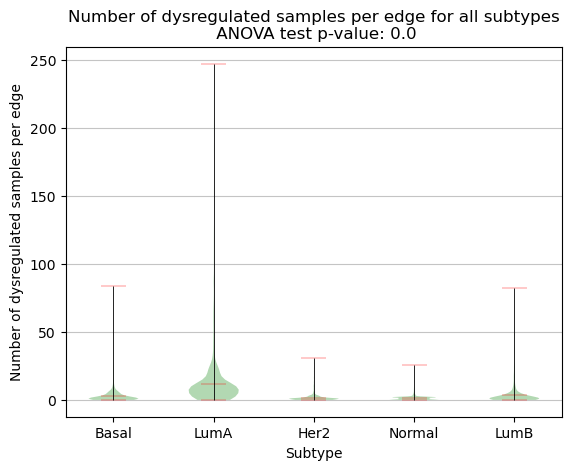

In [47]:
# violin plots showing number of dysregulated samples per edge for each subtype
all_numbs = []
labels = []
for subt in set(subtypes["Subtype_mRNA"]):
    labels.append(subt)
    df = dys
    df["subtype"] = list(subtypes["Subtype_mRNA"])
    df = df.loc[df["subtype"] == subt].drop(columns="subtype")
    edges_dys_numb = []
    for c in df:
        edges_dys_numb.append(sum(1 for n in list(df[c]) if n != 0.0) )
    all_numbs.append(edges_dys_numb)
    
from scipy.stats import f_oneway
vals = f_oneway(all_numbs[0], all_numbs[1], all_numbs[2], all_numbs[3], all_numbs[4])
    
fig, ax = plt.subplots()
ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax.set_ylabel('Number of dysregulated samples per edge')
ax.set_xlabel('Subtype')
violin = ax.violinplot(all_numbs, showmeans=True)

for partname in ('cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("red")
    vp.set_linewidth(0.3)
vp = violin['cbars']
vp.set_edgecolor("black")
vp.set_linewidth(0.6)
    
for pc in violin["bodies"]:
    pc.set_facecolor("green")
    pc.set_alpha(0.3)
# plt.show()
plt.grid(axis='y', alpha=0.75)
plt.title(f"Number of dysregulated samples per edge for all subtypes\n ANOVA test p-value: {vals.pvalue}")
plt.savefig("../data/figures/samples_per_edge_violin.png")

/tmp/ipykernel_2586852/1605531572.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subtype"] = list(subtypes["Subtype_mRNA"])
/tmp/ipykernel_2586852/1605531572.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subtype"] = list(subtypes["Subtype_mRNA"])
/tmp/ipykernel_2586852/1605531572.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

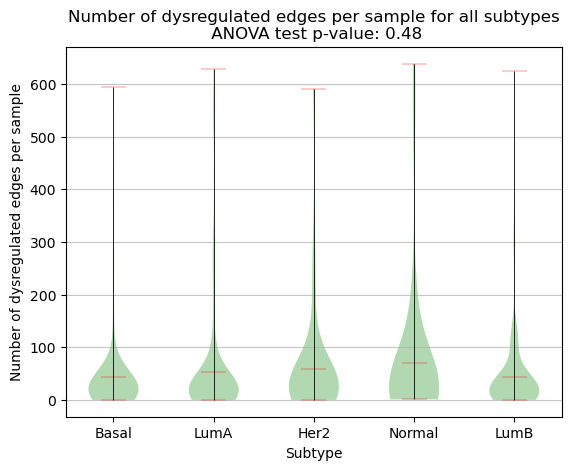

In [46]:
# violin plots showing number of dysregulated edges per samples for each subtype
all_numbs1 = []
labels1 = []
for subt in set(subtypes["Subtype_mRNA"]):
    labels1.append(subt)
    df = dys
    df["subtype"] = list(subtypes["Subtype_mRNA"])
    df = df.loc[df["subtype"] == subt].drop(columns="subtype")
    samples_dys_numb = []
    for index, row in df.iterrows():
        samples_dys_numb.append(sum(1 for n in list(row) if n != 0.0))
    all_numbs1.append(samples_dys_numb)
    
from scipy.stats import f_oneway
vals = f_oneway(all_numbs1[0], all_numbs1[1], all_numbs1[2], all_numbs1[3], all_numbs1[4])
        
fig, ax1 = plt.subplots()
ax1.set_xticks(np.arange(1, len(labels1) + 1), labels=labels1)
ax1.set_ylabel('Number of dysregulated edges per sample')
ax1.set_xlabel('Subtype')
violin1 = ax1.violinplot(all_numbs1, showmeans=True)

for partname in ('cmins', 'cmaxes', 'cmeans'):
    vp = violin1[partname]
    vp.set_edgecolor("red")
    vp.set_linewidth(0.3)
vp = violin1['cbars']
vp.set_edgecolor("black")
vp.set_linewidth(0.6)
    
for pc in violin1["bodies"]:
    pc.set_facecolor("green")
    pc.set_alpha(0.3)
    
# plt.show()
plt.grid(axis='y', alpha=0.75)
plt.title(f"Number of dysregulated edges per sample for all subtypes\n ANOVA test p-value: {round(vals.pvalue,2)}")
plt.savefig("../data/figures/edges_per_sample_violin.png")

## Create bed files for LOLA enrichment

In [80]:
g = load_graph("../data/graph-tool/allCelltypeGraph.gt")

In [81]:
rems = {}
for e in tqdm(g.edges()):
    rem = e.source()
    rems[g.vp.name[rem]] = [g.vp.chr[rem], g.vp.start[rem], g.vp.end[rem]]

2404861it [00:16, 146345.89it/s]


In [82]:
dys_no_sub = dys.drop(columns="subtype")
for row in range(len(dys_no_sub.index)):
    df = dys_no_sub.iloc[[row]]
    df = df.loc[:, df.any()]
    rem_list = {}
    for i in df.columns:
        rem = i.split(",")[0].replace("'", "").replace("'", "").replace("(", "")
        rem_info = rems.get(rem)
        rem_list[rem] = rem_info
    if len(rem_list) != 0:
        file = open(f"../data/TCGA/BRCA/bed_files/{df.index[0]}_dys_edges.bed", "w")
        for r, l in rem_list.items():
            file.write(f"{l[0]}\t{l[1]}\t{l[2]}\t{r}\n")
        file.close()

In [83]:
# different number than in dys, because dys edges with same CREMs to multiple genes
rems_dys = {}
for i in dys_edges.keys():
    rem = i.split(",")[0]
    rem_info = rems.get(rem)
    rems_dys[rem] = rem_info

In [84]:
# create bed files

dys_rem = open("../data/TCGA/BRCA/dys_rems_BRCA.bed", "a")
for r, l in rems_dys.items():
    dys_rem.write(f"{l[0]}\t{l[1]}\t{l[2]}\t{r}\n")
dys_rem.close()